# **Tiktok - ML - Graphical User Interface - Random Forest - Extreme Gradient Boosting  - Classification Model**

## **Introduction:**

In the vibrant and fast-paced world of TikTok, our mission is to inspire creativity and bring joy to millions of users worldwide. As our platform continues to grow rapidly, so do the challenges associated with moderating content to ensure a safe and enjoyable experience for all users. One such challenge is the timely and effective review of user reports, particularly those related to identifying videos and comments containing claims.

The current process of reviewing user reports generates a large volume of data that is challenging to handle efficiently. This backlog not only strains our moderation resources but also impacts the overall user experience. To address this issue, TikTok is actively working on the development of a predictive model that can automatically identify videos containing claims or opinions. By implementing such a model, we aim to streamline the moderation process, reduce the backlog of user reports, and prioritize them more effectively.

This project represents a critical initiative within TikTok's data team, as we strive to leverage machine learning techniques to enhance the platform's content moderation capabilities. In the following sections, we will outline the remaining tasks necessary to complete the claims classification project, including model building, evaluation, and summarizing findings for cross-departmental stakeholders. By successfully implementing this final machine learning model, we aim to make a tangible impact on TikTok's ability to maintain a safe and engaging environment for our diverse community of users.

### **Problem Statement:**

### TikTok faces a challenge in efficiently moderating user-generated content due to the overwhelming volume of user reports; a predictive model for claims classification is being developed to automate identification, reducing backlog and enabling prioritized moderation.

###  **Objective**

### Developing a machine learning model for claims classification will streamline content moderation on TikTok, enabling timely identification of videos containing claims or opinions, thereby improving efficiency and enhancing user experience.

# **PACE  - Problem-Solving Framework**

<img src="images/Pace.png" width="100" height="100" align=left>

# **PACE stages**

#### 1. **Plan:** This stage involves defining the problem clearly, outlining the goals you want to achieve, and exploring potential approaches.

#### 2. **Analyze:** Here, information gathered relevant to the problem, identify patterns, and assess the strengths and weaknesses of different approaches from the planning stage.

#### 3. **Construct:** Based on the analysis, this is where you build a solution. It could involve writing code, creating a model, or designing an experiment.

#### 4. **Execute:** Finally,  put solution into action, test it, and evaluate its effectiveness.

<img src="Images/Pace Model.jpg" width="800" height="800" align=centre>

<img src="images/Plan.png" width="100" height="100" align=left>

## **Pace: Plan**

Consider the questions in your PACE Strategy Document to reflect on the Plan stage.

In this stage, consider the following questions:

### **1. Business need and modeling objective**

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported—too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

**`TikTok wants to build a machine learning model to help identify claims and opinions.`** Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**Modeling design and target variable**

The data dictionary shows that there is a column called `claim_status`. This is a binary value that indicates whether a video is a claim or an opinion. This will be the target variable. In other words, for each video, the model should predict whether the video is a claim or an opinion.

**`This is a classification task because the model is predicting a binary class.`**
Select an evaluation metric

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

    False positives: When the model predicts a video is a claim when in fact it is an opinion
    False negatives: When the model predicts a video is an opinion when in fact it is a claim


### **2. Ethical implications of building the model?**
In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.



### **3. Modeling workflow and model selection process**

Previous work with this data has revealed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

<img src="Images/Train_test.jpg" width="800" height="800" align=centre>



### **Task 1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

from xgboost import XGBClassifier,plot_importance
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("tiktok_data.csv")

In [3]:
# lets us see all of the columns
pd.set_option('display.max_columns', None)

<img src="Images/Analyze.png" width="100" height="100" align=left>

## PACE: **Analyze**

Consider the questions in your PACE Strategy Documentto reflect on the Analyze stage.

### **Task 2: Examine data, summary info, and descriptive stats**

Inspect the first five rows of the dataframe.

In [4]:
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


### Get the number of rows and columns in the dataset.

In [5]:
df.shape

(19382, 12)

### Get basic information about the dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


### Generate basic descriptive statistics about the dataset.

In [7]:
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


### Check for and handle missing values

In [8]:
df.isnull().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

There are very few missing values relative to the number of samples in the dataset. Therefore, observations with missing values can be dropped.

### Drop rows with missing values

In [9]:
df = df.dropna(axis=0)

### Check for and handle duplicates

In [10]:
df.duplicated().sum()

0

There are no duplicate observations in the data.

### Check class balance.

In [11]:
df['claim_status'].value_counts(normalize= True)*100

claim_status
claim      50.345839
opinion    49.654161
Name: proportion, dtype: float64

 **`Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.`**

<img src="images/Construct.png" width="100" height="100" align=left>

## **PACE: Construct**
Consider the questions in your PACE Strategy Document to reflect on the Construct stage.

### **Task 3. Feature engineering**


Extract the length (character count) of each `video_transcription_text` and add this to the dataframe as a new column called `text_length` so that it can be used as a feature in the model.

In [12]:
df['text_length'] = df['video_transcription_text'].str.len()

In [13]:
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


### Calculate the average text_length for claims and opinions.

In [14]:
df[['claim_status','text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


### Visualize the distribution of text_length for claims and opinions using a histogram.

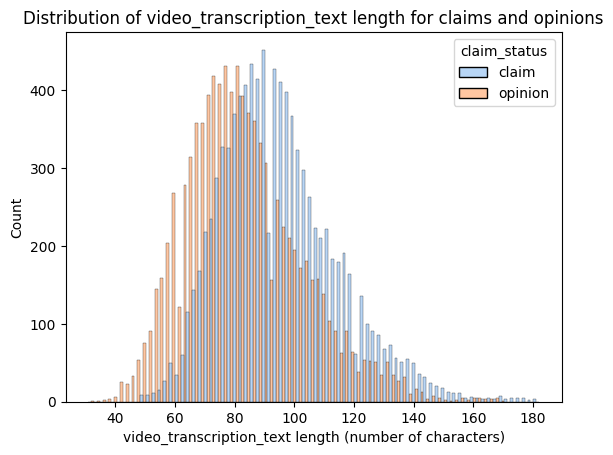

In [15]:
sns.histplot(data=df, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

**Feature selection and transformation**

In [16]:
X = df.copy()

X = X.drop(['#', 'video_id','video_transcription_text'], axis=1)

X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})

X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)

X[['verified_status_verified','author_ban_status_banned','author_ban_status_under review']] = X[['verified_status_verified','author_ban_status_banned','author_ban_status_under review']].astype(int)     

X.head()



,claim_status,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


### **Task 4. Split the data**

Assign target variable.

    In this case, the target variable is `claim_status`.
* 0 represents an opinion
* 1 represents a claim

In [17]:
y = X['claim_status']

In [18]:
df_model = X

In [19]:
df_model.shape

(19084, 11)

In [20]:
X = X.drop(columns='claim_status')
X_all = X
X

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,31,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,25,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,19,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0
...,...,...,...,...,...,...,...,...,...,...
19079,49,6067.0,423.0,81.0,8.0,2.0,65,0,0,0
19080,23,2973.0,820.0,70.0,3.0,0.0,66,0,0,0
19081,50,734.0,102.0,7.0,2.0,1.0,53,0,0,0
19082,8,3394.0,655.0,123.0,11.0,4.0,80,0,0,0


#### **Task 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [21]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [23]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 10), (3817, 10), (3817, 10), (11450,), (3817,), (3817,))

### **Task 6. Build models**

### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [24]:
# Instantiate the random forest classifier
### YOUR CODE HERE ###
rf= RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
### YOUR CODE HERE ###
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
### YOUR CODE HERE ###
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}


# Instantiate the GridSearchCV object
### YOUR CODE HERE ###
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')


In [25]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 6min 30s
Wall time: 6min 36s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [26]:
rf_cv.best_score_

0.9908534395531852

In [27]:

rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

### **Build an XGBoost model**

In [28]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')


In [29]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 14min
Wall time: 4min 3s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [30]:
xgb_cv.best_score_

0.9906808769992594

In [31]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

<img src="images/Execute.png" width="100" height="100" align=left>

## **PACE: Execute**
Consider the questions in your PACE Strategy Document to reflect on the Execute stage.

## **Random forest**

In [32]:
y_pred_rf = rf_cv.best_estimator_.predict(X_val)

In [33]:
y_pred_rf

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [34]:
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model.

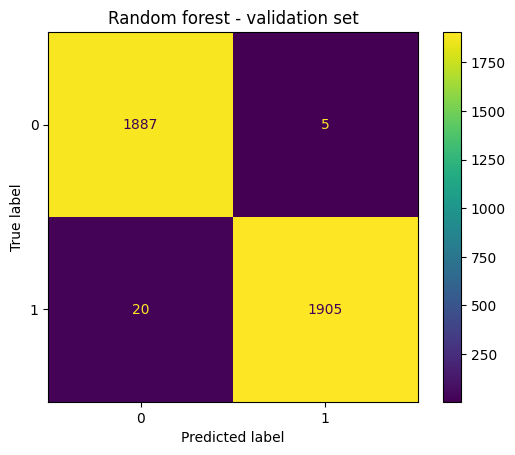

In [35]:
# Create a confusion matrix to visualize the results of the classification model

log_cm = confusion_matrix(y_val, y_pred_rf)

log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

log_disp.plot()

plt.title('Random forest - validation set');
plt.show()

In [36]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred_rf, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



In [37]:
accuracy_rf = round(accuracy_score(y_val, y_pred_rf) * 100, 2)
precision_rf = round(precision_score(y_val, y_pred_rf) * 100, 2)
recall_rf = round(recall_score(y_val, y_pred_rf) * 100, 2)
f1_rf = round(f1_score(y_val, y_pred_rf) * 100, 2)
roc_auc_rf = round(roc_auc_score(y_val, y_pred_rf) * 100, 2)

# Append the metrics to the existing DataFrame
metrics_rf = pd.DataFrame({'Model': ['Random Forest'],
                           'Accuracy Score': [accuracy_rf],
                           'Precision Score': [precision_rf],
                           'Recall Score': [recall_rf],
                           'F1 Score': [f1_rf],
                           'ROC-AUC Score': [roc_auc_rf]
                          })
metrics_rf

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score,ROC-AUC Score
0,Random Forest,99.35,99.74,98.96,99.35,99.35


## **XGBoost**

In [38]:
y_pred_xgb = xgb_cv.best_estimator_.predict(X_val)

In [39]:
y_pred_xgb

array([1, 0, 1, ..., 1, 1, 1])

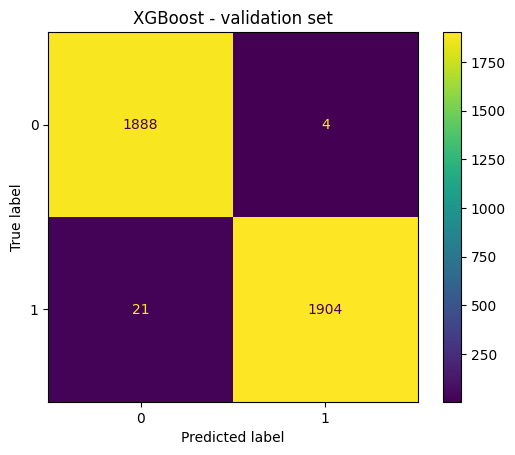

In [40]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred_xgb)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [41]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred_xgb, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



In [42]:
accuracy_xgb = round(accuracy_score(y_val, y_pred_xgb) * 100, 2)
precision_xgb = round(precision_score(y_val, y_pred_xgb) * 100, 2)
recall_xgb = round(recall_score(y_val ,y_pred_xgb) * 100, 2)
f1_xgb = round(f1_score(y_val, y_pred_xgb) * 100, 2)
roc_auc_xgb = round(roc_auc_score(y_test, y_pred_xgb) * 100, 2)

# Append the metrics to the existing DataFrame
metrics_xgb = pd.DataFrame({'Model': ['XGBoost Classifier'],
                             'Accuracy Score': [accuracy_xgb],
                             'Precision Score': [precision_xgb],
                             'Recall Score': [recall_xgb],
                             'F1 Score': [f1_xgb],
                             'ROC-AUC Score': [roc_auc_xgb]
                            })
metrics_xgb

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score,ROC-AUC Score
0,XGBoost Classifier,99.35,99.79,98.91,99.35,50.2


In [43]:
comparision_metrics = pd.concat([metrics_rf,metrics_xgb], ignore_index=True)

comparision_metrics

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score,ROC-AUC Score
0,Random Forest,99.35,99.74,98.96,99.35,99.35
1,XGBoost Classifier,99.35,99.79,98.91,99.35,50.20


### **Using champion model to predict on test data**

Both random forest and XGBoost model architectures resulted in nearly perfect models. Nonetheless, in this case random forest performed a little bit better, so it is the champion model.

Now, use the champion model to predict on the test data.

In [44]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test)
y_pred 

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

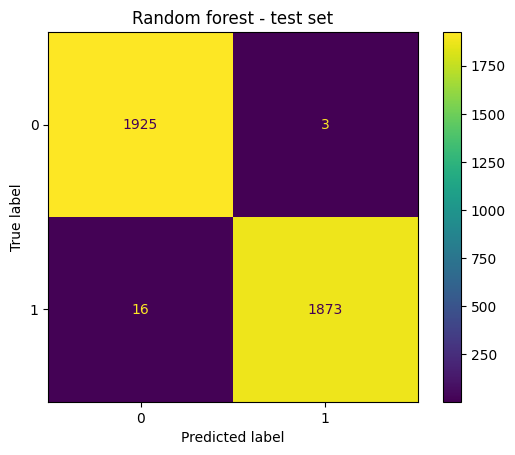

In [45]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

#### **Feature importances of champion model**

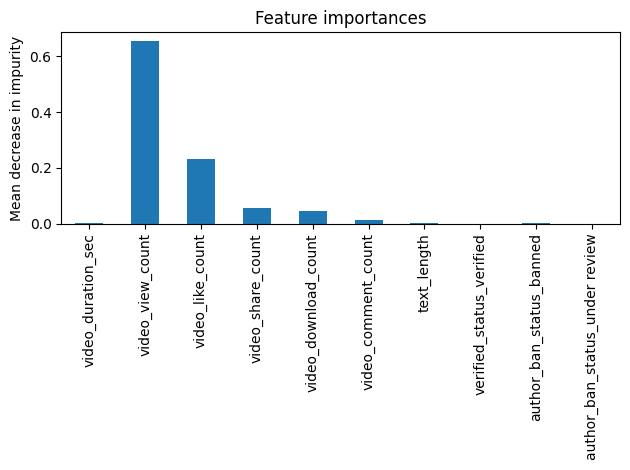

In [46]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

# Conclusion 
1. *Would you recommend using this model? Why or why not?*
Yes, one can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F<sub>1</sub> scores were consistently high. The model very successfully classified claims and opinions.
</br>
2. *What was your model doing? Can you explain how it was making predictions?*
The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.
</br>
3. *Are there new features that you can engineer that might improve model performance?*
Because the model currently performs nearly perfectly, there is no need to engineer any new features.
</br>
4. *What features would you want to have that would likely improve the performance of your model?*
The current version of the model does not need any new features. However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.

## **Saving the trained model to a pickle file**

In [47]:
# Define the path to the folder where you want to save the model
path = 'F:/Case study/Interview preparation/01.Project/2. TikTok/Final/'

In [48]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [49]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [50]:
write_pickle(path,rf_cv,'Tiktok_RF_gui')

## **Prediction :**

In [51]:
y_model = rf_cv.best_estimator_.predict(X_all)
y_pred_df = pd.DataFrame({'Predicted Values': y_model})
result = pd.merge(df_model,y_pred_df,left_index=True, right_index=True)

In [52]:
result.head(1)

,claim_status,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,Predicted Values
0,1,59,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1,1


In [53]:
result_model = result[['video_duration_sec', 'video_view_count', 'video_like_count',
                   'video_share_count', 'video_download_count', 'video_comment_count',
                   'text_length', 'verified_status_verified', 'author_ban_status_banned',
                   'author_ban_status_under review','claim_status','Predicted Values']]

In [54]:
result_model.sample(5)

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,claim_status,Predicted Values
10269,16,1549.0,431.0,11.0,11.0,1.0,72,0,0,0,0,0
11426,55,8659.0,867.0,122.0,12.0,2.0,65,0,0,0,0,0
11464,43,5431.0,1542.0,109.0,10.0,0.0,68,0,0,0,0,0
15916,19,2324.0,662.0,103.0,13.0,1.0,80,0,0,0,0,0
16107,29,5025.0,1602.0,640.0,38.0,13.0,101,1,0,0,0,0


##  **Graphical User Interface (GUI)**

In [ ]:
from tkinter import *
import pickle 
from sklearn import *

def show_entry_fields():
    p1=float(e1.get())
    p2=float(e2.get())
    p3=float(e3.get())
    p4=float(e4.get())
    p5=float(e5.get())
    p6=float(e6.get())
    p7=float(e7.get())
    p8=float(e8.get())
    p9=float(e9.get())
    p10=float(e10.get())
    
  
    model = read_pickle(path,'Tiktok_RF_gui')

    input_features = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10]
   
    
    print('input_features',input_features)
     
    result5=model.predict([input_features])
    
    if result5 == 0:
        label_text = 'video is an Opinion'
    else:
        label_text = 'video is a claim'
        
    Label(master, text=label_text).grid(row=16)
    Label(master,text=result5).grid(row=17)
    print(label_text, result5)
        
         
master = Tk()
master.title("Taxi Fares Estimater")

label = Label(master, text = " Predicting Taxi Fare Amount Using Machine Learning"
                          , bg = "black", fg = "white"). \
                               grid(row=0,columnspan=2)

Label(master, text="video_duration_sec - [5 to 60]  ").grid(row=1)
Label(master, text="passenger_count [20 to 9,99,817]").grid(row=2)
Label(master, text="video_like_count[0 to 6,57,830]").grid(row=3)
Label(master, text="video_share_count [0 to 2,56,130]").grid(row=4)
Label(master, text="video_download_count [0 to 14,994]").grid(row=5)
Label(master, text="video_comment_count [0 to 9,599]").grid(row=6)
Label(master, text="text_length [31 to 182]").grid(row=7)
Label(master, text="verified_status_verified [0,1]").grid(row=8)
Label(master, text="author_ban_status_banned [0,1]").grid(row=9)
Label(master, text="author_ban_status_under review [0,1]").grid(row=10)

e1 = Entry(master)
e2 = Entry(master)
e3 = Entry(master)
e4 = Entry(master)
e5 = Entry(master)
e6 = Entry(master)
e7 = Entry(master)
e8 = Entry(master)
e9 = Entry(master)
e10 = Entry(master)

e1.grid(row=1, column=1)
e2.grid(row=2, column=1)
e3.grid(row=3, column=1)
e4.grid(row=4, column=1)
e5.grid(row=5, column=1)
e6.grid(row=6, column=1)
e7.grid(row=7, column=1)
e8.grid(row=8, column=1)
e9.grid(row=9, column=1)
e10.grid(row=10, column=1)

Button(master, text='Predict', command=show_entry_fields).grid()

mainloop()